필요한 모듈 불러오기

In [1]:
import os, sys
sys.path.append("../source")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'D2Coding'

from Investar import Analyzer

mk = Analyzer.MarketDB()

## 볼린저 밴드 매매기법

- 주의 : 밴드 태그(주가가 밴드에 닿는 현상)가 일어났다고 해서 그 자체로 매수 신호나 매도 신호가 되는 것이 아니다!!
- %b는 볼린저 밴드 어디에 주가가 위치하는지를 나타내며 주가와 연계해 트레이딩 시스템을 구축할 때 필요한 핵심 수단이다.
- 밴드폭은 밴드의 너비를 수치로 나타낸 것으로 추세의 시작과 끝을 포착하는 역할을 한다.
- __변동성과 추세는 볼린저 밴드를 구축할 때 이미 반영되었으므로 이 두 가지를 주가의 움직임을 확증하는 근거로 삼으면 안된다.__
- 확증에 활용할 지표들은 범주별로 하나씩만 고르면 된다.
    + 모멘텀 : 변화율, 스토캐스틱
    + 추세 : 선형회귀, MACD
    + 거래량 : 일중강도(II), 매집/분산(A/D), 현금흐름지표(MFI), 거래량가중 MACD
    + 과매수/과매도 : CCI, RSI
    + 심리 : 여론조사선, 풋-콜 비율
    
- 존 볼린저는 '변동성 돌파', '추세 추종', '반전'이라는 세 가지 매매기법을 제시했다.
    + 실제로 적용해보고 가장 잘 맞는 기법을 사용하라고 함.
- 변동성 돌파 : 주가가 상단 밴드를 상향 돌파할 때 매수하고 주가가 하단 밴드를 하향 이탈할 때 공매도하는 기법으로, 우리나라에서 일반인은 공매도가 어렵다.

- 해당 교재에서는 '추세 추종'과 '반전'을 파이썬으로 구현한다.

### 볼린저 밴드를 이요한 추세 추종 매매기법

- 상승 추세에 매수하고 하락 추세에 매도하는 기법이다.
- %b 만으로 상승/하락 추세의 시작을 판단하지 않는다. MFI나 일중강도 같은 거래량 관련 지표를 함께 이용해서 확증이 이루어진 경우에만 매수/매도에 들어간다.
    + 매수 : 주가가 상단밴드에 접근 & 지표가 강세를 확증할 때만 매수(%b > 0.8 & MFI > 80)
    + 매도 : 주가가 하단밴드에 접근 & 지표가 약세를 확증할 때만 매도(%b < 0.2 & MFI < 20)

- MFI (현금흐름지표, Money Flow Index)
    + 중심가격(Typical Price) : 일정 기간의 고가, 저가, 종가를 합한뒤 3으로 나눈값
    + 이 중심가격을 사용하면 트레이딩이 집중적으로 발생하는 주가 지점을 더 잘 나타낼 수 있다.
    + 현금흐름(Money Flow)은 중심가격 * 거래량이다.
    + __거래량 지표들은 일반적으로 주가에 선행한다는 특징이 있다.__
    + MFI는 거래량 데이터에 RSI 개념을 도입한 지표로 생각할 수 있다.
    + $ MFI = 100 - (100 \div (1 + \frac{긍정적 현금흐름}{부정적 현금흐름} ) ) $
        + 긍정적 현금흐름 : 중심가격이 전일보다 상승한 날들, 즉, 상승일 동안의 현금 흐름의 합
        + 부정적 현금흐름 : 중심가격이 전일보다 하락한 날들, 즉, 하락일 동안의 현금 흐름의 합

- 10일 기준의 MFI를 구해보자.

In [2]:
df = mk.get_daily_price('NAVER', '2020-06-01')

df['MA20'] = df['close'].rolling(window=20).mean()
df['stddev'] = df['close'].rolling(window=20).std()
df['upper'] = df['MA20'] + (df['stddev'] * 2)
df['lower'] = df['MA20'] - (df['stddev'] * 2)
df['PB'] = (df['close'] - df['lower']) / (df['upper'] - df['lower'])
df['bandwidth'] = (df['upper'] - df['lower']) / df['MA20'] * 100
df['TP'] = (df['high'] + df['low'] + df['close']) / 3

# df['PMF'] = 0
# df['NMF'] = 0
# for i in range(len(df.close)-1):
#     if df.TP.values[i] < df.TP.values[i+1]:
#         df.PMF.values[i+1] = df.TP.values[i+1] * df.volume.values[i+1]
#         df.NMF.values[i+1] = 0
#     else:
#         df.NMF.values[i+1] = df.TP.values[i+1] * df.volume.values[i+1]
#         df.PMF.values[i+1] = 0

df['PMF'] = df[df['TP'].diff().fillna(0) > 0].apply(lambda x: x['TP'] * x['volume'], axis=1)
df['PMF'].fillna(0, inplace=True)
df['PMF'] = df['PMF'].astype(int)

df['NMF'] = df[df['TP'].diff().fillna(0) <= 0].apply(lambda x: x['TP'] * x['volume'], axis=1).astype(int)
df['NMF'].fillna(0, inplace=True)
df['NMF'] = df['NMF'].astype(int)
df['NMF'].iloc[0] = 0

df['MFI'] = df['PMF'].rolling(window=10).sum() / df['NMF'].rolling(window=10).sum()
df['MFI10'] = 100 - 100 / (1 + df['MFI'])

df = df[19:]

end_date is initialized to '2021-10-11'


/opt/conda/envs/finance/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


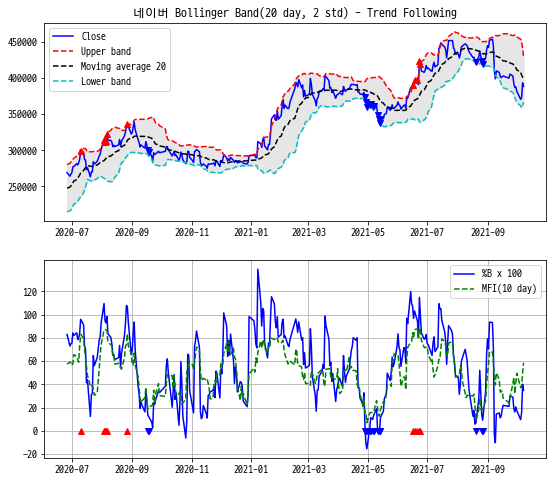

In [4]:
plt.figure(figsize=(9, 8))
plt.subplot(2, 1, 1)
plt.title('네이버 Bollinger Band(20 day, 2 std) - Trend Following')

plt.plot(df.index, df['close'], color='#0000ff', label='Close')
plt.plot(df.index, df['upper'], 'r--', label='Upper band')
plt.plot(df.index, df['MA20'], 'k--', label='Moving average 20')
plt.plot(df.index, df['lower'], 'c--', label='Lower band')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
for i in range(len(df['close'])):
    if df["PB"].values[i] > 0.8 and df['MFI10'].values[i] > 80:
        plt.plot(df.index.values[i], df['close'].values[i], 'r^')
    elif df["PB"].values[i] < 0.2 and df['MFI10'].values[i] < 20:
        plt.plot(df.index.values[i], df['close'].values[i], 'bv')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.plot(df.index, df['PB'] * 100, color='b', label='%B x 100')
plt.plot(df.index, df['MFI10'], 'g--', label='MFI(10 day)')
plt.yticks([-20, 0, 20, 40, 60, 80, 100, 120])
for i in range(len(df['close'])):
    if df["PB"].values[i] > 0.8 and df['MFI10'].values[i] > 80:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df["PB"].values[i] < 0.2 and df['MFI10'].values[i] < 20:
        plt.plot(df.index.values[i], 0, 'bv')

plt.grid(True)
plt.legend(loc='best')
plt.show()

### 볼린저 밴드를 이용한 반전 매매기법

- 반전 매매기법은 주가가 반전하는 지점을 찾아내 매수 또는 매도하는 기법이다.
- 주가가 하단 밴드를 여러 차례 태그하는 과정에서 강세 지표가 발생하면 매수하고, 상단 밴드를 여러 차례 태그하는 과정에서 약세 지표가 발생하면 매도한다.
- 존 볼린저는 일중강도율(Intraday Intensity, %)과 매집분산율(AD%)을 기술적 지표의 예로 들었다.
- 교재에서는 매도/매수 조건의 일관성을 고려해서 기술적 지표는 일중강도율 하나만 사용한다.
    + 매수 : 주가가 하단 밴드부근에서 W형 패턴을 나타내고, 강세지표가 확증할 때 매수(%b < 0.05 & II%가 0보다 크면 매수)
    + 매도 : 상단 밴드부근에서 일련의 주가 태그가 일어나며, 약세지표가 확증할 때 매도(%b > 0.95 & II%가 0보다 작으면 매도)
    
- 일중 강도
    + 데이빗 보스티언이 개발한 거래량 지표이다.
    + 거래 범위에서 종가의 위치를 토대로 주식 종목의 자금 흐름을 설명한다.
    + II는 장이 끝나는 시점에서 트레이더들의 움직임을 나타낸다.
    + 종가가 거래 범위 천정권에서 형성되면 1, 중간에 형성되면 0, 바닥권에서 형성되면 -1이 된다.
    + 21일 기간 동안의 II합을 21일 기간 동안의 거래량 합으로 나누어 표준화한 것이 일중 강도율이다.
    + $ 일중강도 = \frac{2 \times 종가 - 고가 - 저가}{고가 - 저가} \times 거래량 $
    + $ 일중강도율 = \frac{일중강도의21일합}{거래량의21일합} \times 100 $

- SK하이닉스 볼린저 밴드와 일중강도율

In [5]:
df = mk.get_daily_price('NAVER', '2019-01-02')

df['MA20'] = df['close'].rolling(window=20).mean()
df['stddev'] = df['close'].rolling(window=20).std()
df['upper'] = df['MA20'] + (df['stddev'] * 2)
df['lower'] = df['MA20'] - (df['stddev'] * 2)
df['PB'] = (df['close'] - df['lower']) / (df['upper'] - df['lower'])
df['bandwidth'] = (df['upper'] - df['lower']) / df['MA20'] * 100
df['TP'] = (df['high'] + df['low'] + df['close']) / 3

df['II'] = (2*df['close'] - df['high'] - df['low']) / (df['high'] - df['low']) * df['volume']
df['IIP21'] = df['II'].rolling(window=21).sum() / df['volume'].rolling(window=21).sum() * 100
df = df.dropna()

end_date is initialized to '2021-10-11'


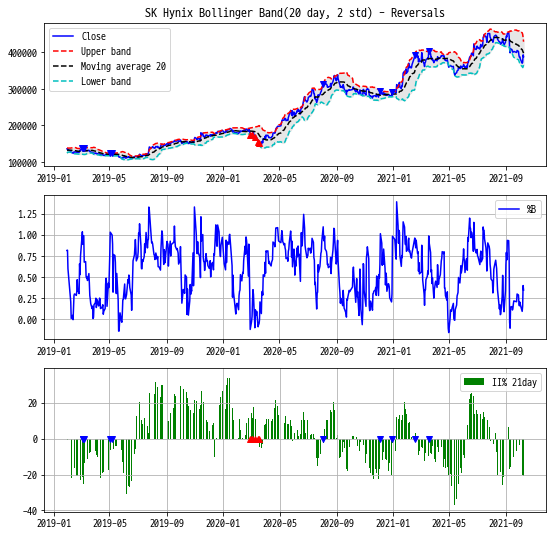

In [6]:
plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
plt.title('SK Hynix Bollinger Band(20 day, 2 std) - Reversals')

plt.plot(df.index, df['close'], color='#0000ff', label='Close')
plt.plot(df.index, df['upper'], 'r--', label='Upper band')
plt.plot(df.index, df['MA20'], 'k--', label='Moving average 20')
plt.plot(df.index, df['lower'], 'c--', label='Lower band')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
for i in range(len(df['close'])):
    if df['PB'].values[i] < 0.05 and df['IIP21'].values[i] > 0:
        plt.plot(df.index.values[i], df['close'].values[i], 'r^')
    elif df['PB'].values[i] > 0.95 and df['IIP21'].values[i] < 0:
        plt.plot(df.index.values[i], df['close'].values[i], 'bv')
        
plt.legend(loc='best')

plt.subplot(3, 1, 2)
plt.plot(df.index, df['PB'], color='b', label='%B')
plt.grid(True)
plt.legend(loc='best')

plt.subplot(3, 1, 3)
plt.bar(df.index, df['IIP21'], color='g', label='II% 21day')
for i in range(len(df['close'])):
    if df['PB'].values[i] < 0.05 and df['IIP21'].values[i] > 0:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df['PB'].values[i] > 0.95 and df['IIP21'].values[i] < 0:
        plt.plot(df.index.values[i], 0, 'bv')
plt.grid(True)
plt.legend(loc='best')

plt.show()

- 일중강도율은 기관 블록 거래자의 활동을 추적할 목적으로 만들어진 지표다.
- 존 볼린저는 일중강도율을 볼린저 밴드를 확증하는 도구로 사용한다.
    + 주가가 하단 볼린저 밴드에 닿을 때, 일중강도율이 +이면 매수
    + 주가가 상단 볼린저 밴드에 닿을 때, 일중강도율이 -이면 매도

## 심리투자 법칙

- 알렉산더 엘더 "주식시장에서 살아남는 심리투자 법칙"
- 3가지 성공요소 : 3M
    + 정신(Mind) : 시장 노이즈에 휩쓸리지 않도록 해주는 원칙
    + 기법(Method) : 시장 지표를 활용해 주가를 분석하고 이를 매매에 활용하는 기법
    + 자금(Money) : 리스크를 거래의 일부로 포함시키는 자금 관리

### 시장 지표

- 추세, 오실레이터, 기타지표 등이 있다.
- (1) __추세 : 시장 흐름을 나타내는 지표, 동행 또는 후행, 시장 횡보활때 잘못된 신호를 보낼 수 있다.__
    + 이동평균(Moving Averages)
    + 이동평균 수렴확산(MACD)
    + MACD 히스토그램
    + 방향성 시스템(the Directional System)
    + 거래량 균형 지표(On-Balance Volume, OBV)
    + 누적분산 지표(Accumulation/Distribution, AD)
    
    
- (2) __오실레이터 : 과거 일정 기간의 가격 범위안에서 현재 가격의 상대적인 위치를 나타내는 지표, 선행 또는 동행, 횡보장에서 전환점을 포착하는데 적합하지만 가격보다 앞서 변하는 경향이 있다.__
    + 스토캐스틱(Stochastic)
    + 변화율(Rate of Change)
    + 평활화된 변화율(Smoothed RoC)
    + 모멘텀(Momentum)
    + 상대강도지수(Relative Strength Index, RSI)
    + 엘더레이(Elder-ray)
    + 강도지수(the Force Index)
    + 윌리엄스(Williams %R)
    + 상대가격변동폭(the Commodity Channel Index)
    
    
- (3) __기타지표 : 강세장과 약세장에 따른 강도 예측, 선행 또는 동행__
    + 신고점-신저점 지수(New High-New Low Index)
    + 풋-콜 비율(the Put-Call Ratio)
    + 상승하락 지수(the Advance/Decline Index, A/D)
    + 트레이더 지수(the Trader's Index, TRIN)

### 단순 이동평균

- 이동평균선 진행 방향을 보면 전반적인 가격 흐름 예측 가능
- 오래된 가격의 변동과 최근 가격의 변동을 동일하게 반영하기 때문에 최근 가격의 변동이 왜곡될 가능성이 있다.


### 지수 이동평균

- 최근 데이터에 가중치를 부여해 단순 이동평균에 비해 최근의 데이터 변동을 잘 반영하도록 설계되었다.
- $ EMA = P_{today} \times K + EMA_{yesterday} \times (1 - K) $
    + $ K: \frac{2}{N+1}, N: 지수 이동평균 일수, P_{today}: 오늘 가격, EMA_{yesterday} : 어제의 지수이동평균 $
- 단순 이동평균에 비해 2가지 장점 존재
    + (1) 최근 거래일에 더 많은 가중치를 주므로 최근 가격의 변동을 더 잘 나타낸다.
    + (2) 오래된 지수 이동평균 데이터가 천천히 사라지므로 오래된 데이터가 빠져나갈 때 지수 이동평균이 급등락하지 않는다.
- 해당 지표가 오르면 추세가 상승하고 있음을 나타내므로 매수 측에서 매매해야한다.
- 반대로 내리고 있다면 매도 측에서 매매하는 것이 좋다.
- 알렉산더 엘더에 따르면 이동평균의 기간은 시장(the dominant market) 사이클의 절반 정도가 적당하다.
- 20일 주기를 발견했다면 10일 이동평균선을 사용하면 된다.
    + 알렉산더 엘더는 매매시 주로 13일 지수이동평균을 사용한다.

### 이동평균 수렴확산(MACD)

- 제럴드 아펠(뉴욕 애널리스트, 펀드매니저)은 세가지 지수 이동평균선을 이용해 MACD를 개발했다.
- MACD : Moving Average Convergence Divergence
- 실제 MACD 차트에서는 두 선으로 표시되는데, 하나는 MACD선(실선)이고 다른 하나는 신호선(점선)이다.
    + 이 두 선의 교차점에서 매매신호가 발생한다.
    + MACD 선 : 종가의 12일 지수 이동평균선에서 26일 지수 이동평균선을 뺀 것, 가격변화에 상대적으로 빨리 반응한다.
    + 신호선 : MACD 선의 9일 지수 이동평균을 구한 선으로 MACD선을 평활화시킨 것이기 때문에 가격 변화에 상대적으로 늦게 반응한다.
- 빠른 MACD 선이 늦은 신호선을 상향돌파하는 것은 매수세가 시장을 주도한다는 뜻이므로 매수적 관점에서 대응하는 것이 좋다.
- 반대로 빠른 MACD 선이 늦은 신호선을 하향돌파할 때는 매도 관점에서 대응해야한다.

### MACD 히스토그램

- 원래의 MACD보다 매수와 매도 상태를 더 잘 표현한다.
- 매수, 매도의 비중을 표시할 뿐만 아니라 강해지고 있는지 약해지고 있는지를 보여주므로, 기술적 분석가에게는 최고의 도구다.
- MACD 히스토그램 수식
    + $ MACD히스토그램 = MACD선 - 신호선 $
- MACD 히스토그램의 기울기를 확인하는 것은 히스토그램이 중심선(0)위에 있는지 아니면 아래에 있는지 확인하는 것보다 중요하다.
    + 현재 봉이 이전 봉보다 높다면 기울기는 올라가고 있으므로 매수를 해야한다.
    + 최고의 매수 신호는 MACD 히스토그램이 중신선 아래에 있고, 기울기가 상향 반전하고 있을 때 발생한다.
- MACD 히스토그램과 가격과의 다이버전스는 일년에 몇번만 일어나며 기술적 분석에서 가장 강력한 신호다.
    + 가격이 신저점까지 낮아졌으나 MACD 히스토그램이 저점에서 상승하기 시작했다면, 강세 다이버전스(bullish divergence)가 형성됨을 뜻한다.
    + 반면에 가격이 신저점을 갱신하면서 MACD 히스토그램도 낮아지고 있다면 단순히 하향추세 신호다.
    

### 스토캐스틱

- 조지 레인에 의해서 대중화된 오실레이터로서, 지난 n일 동안의 거래 범위에서 현재 가격 위치를 백분율로 나타낸다.
- 14일 스토캐스틱이 70이면 지난 14일간 거래에서 최저점과 최고점 사이 70%에 위치해 있다는 의미이다.
- 일반적으로 80이상은 과매수 상태, 20이하는 과매도 상태를 나타낸다.
- 스토캐스틱은 두 선으로 이루어져 있다.
    + 빠른 선은 %K, 느린 선은 %D다.
    + 일반적으로 %K의 기간은 14일로 설정하지만 알렉산더 엘더는 짧은 반전을 잡아내기 용이한 5일로 설정한다.
    + 반면 기간이 길면 중요 변곡점을 잡아내는데 유용하다.
- %K 수식
    + $ \%K = \frac{C_{today} - L_{n}}{H_{n} - L_{n}} $
- %D 수식
    + $ \%D = \frac{(C_{today} - L_{n})의 3일간 합계}{(H_{n} - L_{n})의 3일간 합계} \times 100 $  
- 시장이 박스권에서 움직일때 잘 작동함. 추세에 들어갈 때는 그렇지 않다.
    + 상승 추세 -> 과매수 상태로 판단 -> 매도신호 보냄. But 계속 상승 가능
    + 하락 추세 -> 과매도 상태로 판단 -> 매수신호 보냄. But 계속 하락 가능
- 따라서, 장기 추세 추종형 지표와 결합해서 사용해야한다.
    + 알렉산더 엘더의 삼중창 매매시스템 : MACD 히스토그램의 주간 추세가 상승하고 있을때, 일간 스토캐스틱에서 매수 신호를 취하도록 설계되었다.

## 삼중창 매매 시스템

- 해당 시스템은 추세 추종과 역추세 매매법을 함께 사용하며, 세 단계의 창을 거쳐 더 정확한 매매 시점을 찾도록 구성되어있다.
- 같은 시장이라도 지표들이 내는 신호들이 서로 다를 수 있다. 해당 시스템은 한 가지 지표만 사용했을 때의 단점을 보완하고자 추세 추종형 지표와 오실레이터를 적절히 결합해 사용한다.
- 중요한 딜레마중 하나는 시간의 관점에 따라 주가 차트가 오를 수도 있고 내릴 수도 있다는 점이다.
    + 예) 일봉 차트에서는 상승 추세라 해도 주봉 차트에서는 하락일 수 있고, 그 반대일 수도 있다.
    + 삼중창은 서로 다른 시간 단위에서 신호를 비교함으로써 정확한 매매 시점을 파악하도록 개발되었다.

### 첫번째 창 - 시장 조류

- 트레이더에게는 매수, 매도, 관망 세 가지 선택지가 주어진다.
- 삼중창의 첫번째 창을 이용하면 이 중 한 선택지를 제거할 수 있다.
    + 시장이 상승 추세인지 하락 추세인지 판단해 상승 추세에서는 매수 or 관망, 하락 추세에서는 매도 or 관망하면 된다.
- 삼중창의 첫번째 창은 시장조류(Market Tide), 즉 장기 차트를 분석하는 것이다.
- 트레이더는 자신이 매매하는 시간 단위보다 한 단계 긴 단위 차트를 이용해 분석하면 된다.
    + 예1) 일간 차트 기준으로 매매 -> 주간 차트로 추세 분석
    + 예2) 5분 차트를 기준으로 매매 -> 30분 봉으로 추세 분석

### 두번째 창 - 시장 파도

- 첫번째 창의 추세 방향과 역행하는 파도(market wave)를 파악하는데 오실레이터를 활용한다.
- 주봉 추세가 상승하고 있을 때, 일봉 추세가 하락하면 매수 기회로 본다.
    + 주간 히스토그램이 상승하고 있을 때(혹은 EMA 130가 상승하고 있을때), 스토캐스틱이 30아래로 내려가면 매수
    + 주간 히스토그램이 하락하고 있을 때(혹은 EMA 130가 하락하고 있을때), 스토캐스틱이 70위로 올라가면 매도

### 세번째 창 - 진입 기술

- 앞의 2개의 창과 달리 해당 창에서는 차트나 지표를 필요로 하지 않는다.
- 첫번째 창과 두번째 창이 동시에 매매 신호를 냈을때 진입 시점을 찾아내는 기법만 존재한다.
- 주간 추세 / 일간 오실레이터 / 행동 / 주문 순서대로 아래와 같이 정리할 수 있다.
    + 상승 / 상승 / 관망 / -
    + 상승 / 하락 / 매수 / 추적 매수 스톱
    + 하락 / 하락 / 관망 / - 
    + 하락 / 상승 / 매도 / 추척 매도 스톱
- 추적 매수 스톱 : 주간 추세가 상승하고 있을 때, 일간 오실레이터가 하락하면 매수 신호가 발생하면 전일 고점보다 한 틱 위에서 매수 주문을 낸다.
- 추척 매도 스톱 : 주간 추세가 하락하고 있을 때, 일간 오실레이터가 상승하면 매도 신호가 발생하면 전일 저점보다 한 틱 아래에서 매도 주문을 낸다.

- 매수, 매도 시점도 같이 한번에 구현해본다.

In [28]:
import datetime
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

In [48]:
stock_name = '엔씨소프트'
df = mk.get_daily_price(stock_name, '2019-01-01')

end_date is initialized to '2021-10-11'


In [49]:
ema60 = df['close'].ewm(span=60).mean() # 종가의 12주 지수 이동평균
ema130 = df['close'].ewm(span=130).mean() # 종가의 26주 지수 이동평균
macd = ema60 - ema130 # MACD선
signal = macd.ewm(span=45).mean() # 신호선(MACD의 9주 지수 이동평균)
macdhist = macd - signal # MACD 히스토그램

In [50]:
kwargs = dict(
    ema130=ema130,
    ema60=ema60,
    macd=macd,
    signal=signal,
    macdhist=macdhist,
)

In [51]:
df = df.assign(**kwargs).dropna()
df['number'] = df.index.map(mdates.date2num)
ohlc = df[['number', 'open', 'high', 'low', 'close']]

In [52]:
ndays_high = df['high'].rolling(window=14, min_periods=1).max()
ndays_low = df['low'].rolling(window=14, min_periods=1).min()
fast_k = (df['close'] - ndays_low) / (ndays_high - ndays_low) * 100
slow_d = fast_k.rolling(window=3).mean()
df = df.assign(fast_k=fast_k, slow_d=slow_d).dropna()

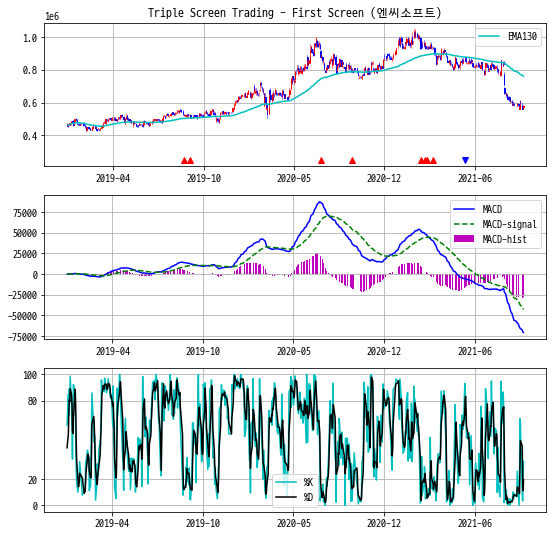

In [53]:
plt.figure(figsize=(9, 9))
p1 = plt.subplot(3, 1, 1)
plt.title(f'Triple Screen Trading - First Screen ({stock_name})')
plt.grid(True)

candlestick_ohlc(p1, ohlc.values, width=.6, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.plot(df['number'], df['ema130'], color='c', label='EMA130')
for i in range(1, len(df['close'])):
    if df['ema130'].values[i-1] < df['ema130'].values[i] and \
        df['slow_d'].values[i-1] >= 20 and df['slow_d'].values[i] < 20:
        plt.plot(df['number'].values[i], 250000, 'r^')
    elif df['ema130'].values[i-1] > df['ema130'].values[i] and \
        df['slow_d'].values[i-1] <= 80 and df['slow_d'].values[i] > 80:
        plt.plot(df['number'].values[i], 250000, 'bv')
plt.legend(loc='best')

p2 = plt.subplot(3, 1, 2)
plt.grid(True)
p2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.bar(df['number'], df['macdhist'], color='m', label='MACD-hist')
plt.plot(df['number'], df['macd'], color='b', label='MACD')
plt.plot(df['number'], df['signal'], 'g--', label='MACD-signal')
plt.legend(loc='best')

p2 = plt.subplot(3, 1, 3)
plt.grid(True)
p2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.plot(df['number'], df['fast_k'], color='c', label='%K')
plt.plot(df['number'], df['slow_d'], color='k', label='%D')
plt.yticks([0, 20, 80, 100])
plt.legend(loc='best')

plt.show()

- 시장의 장기 추세를 분석하기 위해서 26주(=1년동안 개장일의 절반) 지수 이동평균에 해당하는 EMA 130 그래프와 주간 MACD 히스토그램을 함계 표시하고 있다.
- MACD 히스토그램의 기울기를 보는 방법은 최근 2개의 히스토그램의 높낮이를 비교하면 되는데, 사실 저자도 이야기하듯이 해당 기울기보다는 EMA 130을 사용하는 것이 더 좋다고한다.
    + MACD 히스토그램의 기울기 기반의 신호는 불필요한 매수/매도 신호가 자주 발생한다고한다.
    + 주간 추세추종 지표로써 EMA 130을 사용하고 있다고한다.
- 스토캐스틱에는 빠른 선 %K와 느린 선 %D가 있다. %D가 더 적은 신호를 만들기때문에 그만큼 더 확실한 신호로 볼 수 있다.
- 결론
    + 삼중창 매매 시스템의 첫 번째 창에서 EMA 130 그래프가 오르고 있을 때에만 시장에 참여해라!
    + %K보다는 %D를 사용하라!